In [1]:
import keras

# 주택 가격 예측 문제

## 보스턴 주택 가격 데이터셋
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의  데이터가 주어졌을 때 주택 가격의 중간 값을 예측
데이터 포인트 506개로 비교적 개수가 적고 (훈련샘플 404개, 테스트샘플 102개)

In [5]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [6]:
train_data.shape

(404, 13)

In [7]:
test_data.shape

(102, 13)

- 훈련샘플 404개, 테스트샘플 102개
- 13개의 특성

In [9]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

(천달러 단위)

## 데이터 준비
네트워크가 이런 다양한 데이터에 자동으로 맞출 수 있지만 어렵다. 이런 데이터를 다룰 때 대표적인 바업은 특성별로 정규화하는 것. 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눈다,. 특성의 중앙이 근처 맞춰지고 표준 편차가 1 이된다.

In [10]:
mean = train_data.mean(axis=0) #평균
train_data -= mean
std = train_data.std(axis=0) #표준편차
train_data /= std

test_data -= mean
test_data /= std

테스트 데이터를 정규화 할때 훈련데이터에서 계산한 값.
머신러닝 작업 과정에서 테스트 데이터에서 계산한 어떤 값도 사용하면 안된다. 

# 모델 구성
훈련데이터가 적을 수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 방법이다. 


In [11]:


from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없다. --> 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성
활성화 함수를 적용하면 출력 값의 범위를 제한하게 된다. 

### mse손실 함수: 평균 제곱오차의 약자로 예측과 타깃 사이 거리의 제곱. 회귀문제에서 널리 사용

## K-겹 검증을 사용한 훈련 검증

(훈련에 사용할 에포크의 수 같은) 매개변수들을 조정하면서 모델을 평가하기 위해 데이터를 훈련세트와 검증 세트로 나눈다. 데이터 포인트가 많지 않기 때문에 검증세트도 매우 작아진다. --> 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택되었는지에 따라 검증 점수가 크게 달라진다. -->검증 세트 분할에 대한 검증 점수 분산이 높다-->신뢰도 하락

#### -------> k-겹 검증을 이용
데이터 k개의 분할로 나누고 k개의 모델로 만들어 k-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법, 모델 검증 점수는 k개 검증 점수의 평균이 된다.

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [15]:
all_scores

[2.0595543384552, 2.4134483337402344, 2.583881378173828, 2.460324287414551]

In [14]:
np.mean(all_scores)

2.3793020844459534

검증 세트가 달라 검증점수 편차가 크다. 평균값(2.4)이 각각 점수보다 훨씬 신뢰할만한 점수이다. 

In [16]:


from keras import backend as K

# 메모리 해제
K.clear_session()



In [38]:
import tensorflow as tf

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [39]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [40]:
import matplotlib.pyplot as plt

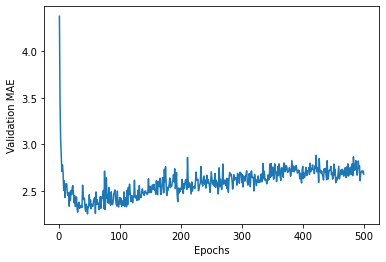

In [41]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 곡선 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외
- 부드로운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지 이동 평균으로 대체

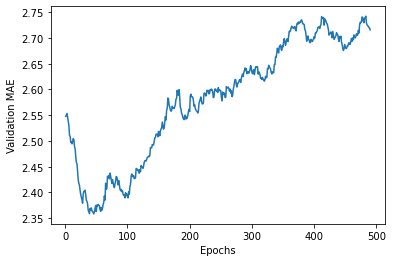

In [42]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])#10개 제외

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [43]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


4/4 [==============================] - 0s 2ms/step - loss: 17.6690 - mae: 2.5948


In [44]:
test_mae_score

2.594820022583008

## 정리

- 회귀는 분류에서와 다른 손실 함수 사용: 평균 제곱 오차(MSE)는 회귀에서 자주 사용
- 회귀에서 사용되는 평가 지표는 분류와 다르다. 
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 한다. 
- 가용 데이터가 적다면 k-겹 검증을 사용
- 가용 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층 수를 줄인다. 
